# Анализ бизнес-показателей маркетинга развлекательного приложения Procrastinate Pro+

## Краткое описание проекта

Несмотря на огромные вложения в рекламу приложения, последние несколько месяцев компания терпит убытки. Доступны данные с сервера с информацией о посещениях сайта, данные по заказам, данные по расходам компании на рекламу.

## Цель проекта

Разобраться в причинах понесённых убытков и помочь компании выйти в плюс.

## План работы

* загрузка данных и подготовка их к анализу;
* задание функции для расчёта и анализа LTV, ROI, удержания и конверсии;
* исследовательский анализ данных;
* подсчёт общих расходов на маркетинг и выяснение как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник;
* оценка окупаемости рекламы как в целом, так и с разбивкой по странам, устройствам и каналас привлечения;
* формирование выводов.

### Загрузка данных и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math

In [3]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

In [4]:
print(visits.head())#первые 5 строк датасета
print(visits.info())

        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  

In [5]:
print(orders.head())#первые 5 строк датасета
print(orders.info())

        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


In [6]:
print(costs.head())#первые 5 строк датасета
print(costs.info())

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


Мы имеем 3 файла, содержащие информацию о посещении приложения, покупках в нём и расходах на рекламу. Можем сделать вывод что пропусков данных нет, типы данных в каждом датафрейме соответствуют их реальному содержимому. Приведём названия колонок во всех датафреёмах к нижнему регистру и "змеиному стилю" и также поищем дубликаты в данных.

Выполним предобработку данных:

Для начала приведём столбцы к нижнему регистру и "змеиному стилю"

In [7]:
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')

Посмотрим имеются ли явные дубликаты:

In [8]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Явных дубликатов не обнаружено

Попробуем найти неявные дубликаты в датафреймах с визитами и рекламными компаниями:

In [9]:
print('Регионы', visits['region'].unique())
print('Каналы', visits['channel'].unique())
print('Устройства', visits['device'].unique())
print('Каналы', costs['channel'].unique())

Регионы ['United States' 'UK' 'France' 'Germany']
Каналы ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
Устройства ['iPhone' 'Mac' 'Android' 'PC']
Каналы ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


Неявных датафреймов не обнаружено

Заменим типы данных временных переменных во всех датасетах:

In [10]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Выводы: <br>
Проведена прдобработка данных где выполнены следующие действия:
* названия столбцов приведены к стандартному виду
* типы временных данных приведены к необходимому типу;
* можно сделать вывод что отсутствуют пропуски и дубликаты.

### Задание функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Зададим функцию для создания профилей пользователей:

In [11]:
def get_profiles (sessions, orders, ad_costs):
    # найдем параметры всех первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg({
                    'session_start': 'first',
                    'channel': 'first',
                    'device': 'first',
                    'region': 'first'
                })
                .rename(columns={'session_start': 'first_ts'})
                .reset_index()
               )
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Зададим функцию для подсчёта Retention Rate

In [12]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Зададим функцию для подсчёта конверсии

In [13]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Зададим функцию для подсчёта LTV

In [14]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Зададим функции для построения графиков. Сначала функцию для сглаживания данных

In [15]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Функция для визуализации удержания:

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Функция для визуализации графика конверсии:

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для визуализации LTV и ROI

In [18]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('CAC')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

Начнём с составления профилей пользователей:

In [19]:
profiles = get_profiles(visits, orders, costs)

Найдем максимальную и минимальную даты привлечения:

<b> Вывод

In [20]:
print(f'''Минимальная дата привлечения пользователей: {profiles['dt'].min()}
Максимальная дата привлечения пользователей: {profiles['dt'].max()}''')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Выясним из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [21]:
users_by_region = (profiles.groupby('region')[['user_id', 'payer']].agg({'user_id': 'count', 'payer':'sum'}).reset_index())
users_by_region['region_percents'] = users_by_region['user_id'] / users_by_region['user_id'].sum()
users_by_region['region_payers_percents'] = users_by_region['payer'] / users_by_region['user_id']
users_by_region2 = users_by_region
users_by_region = users_by_region.style.format({'region_percents': '{:.2%}', 'region_payers_percents': '{:.2%}'})
users_by_region

Пользователи приходят из четырёх стран: Франция, Германия, Великобритания, США. Наибольшее число платящих пользователей в США.

Визуализируем полученные данные:

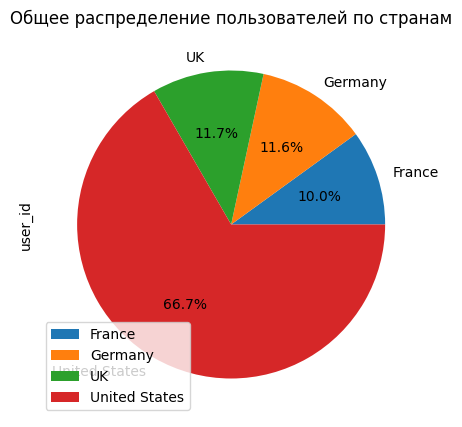

In [22]:
users_by_region2.sort_values(ascending=True, by = 'region_percents').plot(kind='pie', figsize=(5,5), y='user_id', 
                            labels=users_by_region2['region'], autopct='%1.1f%%')
plt.title("Общее распределение пользователей по странам")
plt.show()

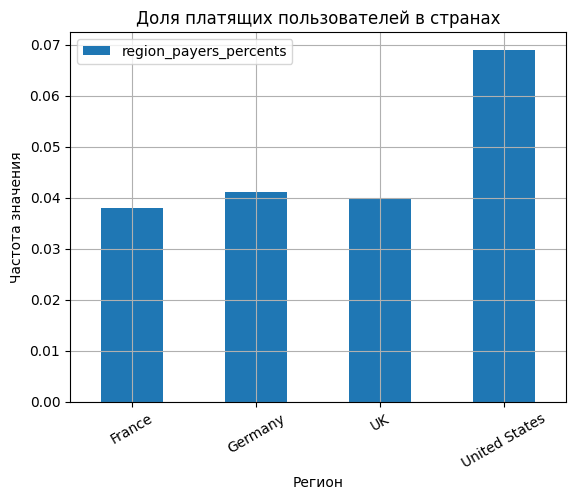

In [23]:
plot = users_by_region2.plot(x="region", y="region_payers_percents", kind='bar', grid=True, rot=30)
plot.set_title("Доля платящих пользователей в странах")
plot.set_xlabel("Регион")
plot.set_ylabel("Частота значения")
plt.show()

<b> Выводы </b>
* большинство пользователей приложения, а именно две трети это пользователи из США, остальные страны имеют почти одинаковую представительность среди пользователей приложения;
* доля платящих пользователей в общем количестве также самая высокая в США: почти 7%

Узнаем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [24]:
users_by_device = (profiles.groupby('device')[['user_id', 'payer']].agg({'user_id': 'count', 'payer':'sum'}).reset_index())
users_by_device['device_payer_percents'] = round(users_by_device['payer'] / users_by_device['user_id'] * 100, 2)
users_by_device

device  user_id  payer  device_payer_percents
0  Android    35032   2050                   5.85
1      Mac    30042   1912                   6.36
2       PC    30455   1537                   5.05
3   iPhone    54479   3382                   6.21

Визуализируем полученные данные:

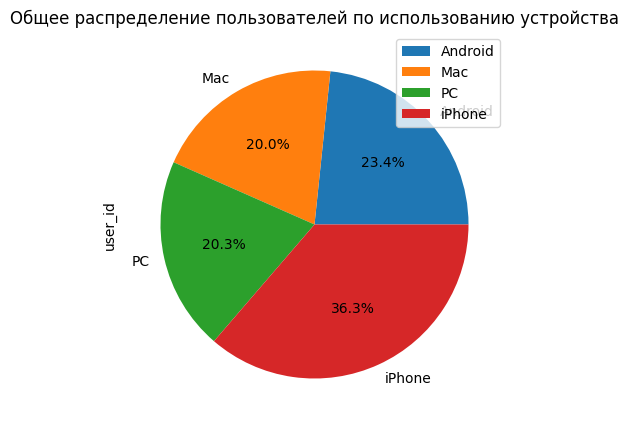

In [25]:
users_by_device.sort_values(ascending=True, by = 'device').plot(kind='pie', figsize=(5,5), y='user_id', 
                            labels=users_by_device['device'], autopct='%1.1f%%')
plt.title("Общее распределение пользователей по использованию устройства")
plt.show()

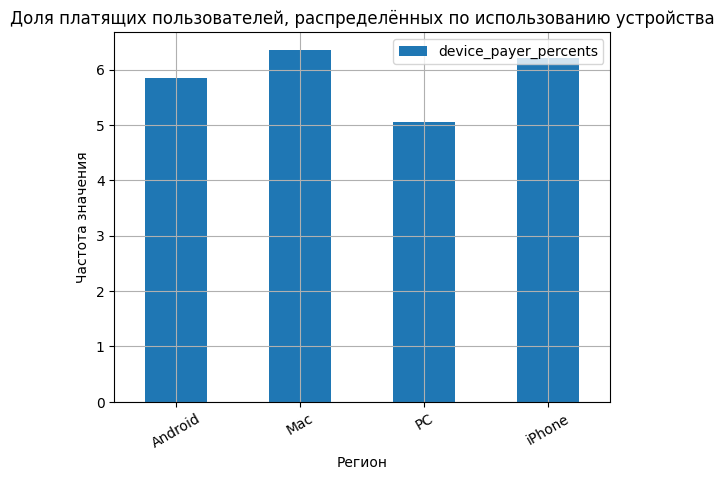

In [26]:
plot = users_by_device.plot(x="device", y="device_payer_percents", kind='bar', grid=True, rot=30)
plot.set_title("Доля платящих пользователей, распределённых по использованию устройства")
plot.set_xlabel("Регион")
plot.set_ylabel("Частота значения")
plt.show()

<b> Выводы </b>
* самое распространенное устройство у пользователей приложения это IPhone - более 36 %, остальные устройства имеют примерно одинаковое распределение;
* наибольший процент оплаты у пользователей Mac(6.36%), наименьший у PC(5.05%)

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Затем построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [27]:
users_by_channel = (profiles.groupby('channel')[['user_id', 'payer']].agg({'user_id': 'count', 'payer':'sum'}).reset_index())
users_by_channel['users_by_channel_percents'] = round(users_by_channel['user_id'] / users_by_channel['user_id'].sum() * 100, 2)
users_by_channel['payers_by_channel_percents'] = round(users_by_channel['payer'] / users_by_channel['user_id'] * 100, 2)
users_by_channel

channel  user_id  payer  users_by_channel_percents  \
0           AdNonSense     3880    440                       2.59   
1             FaceBoom    29144   3557                      19.43   
2              LeapBob     8553    262                       5.70   
3         MediaTornado     4364    156                       2.91   
4   OppleCreativeMedia     8605    233                       5.74   
5       RocketSuperAds     4448    352                       2.97   
6               TipTop    19561   1878                      13.04   
7       WahooNetBanner     8553    453                       5.70   
8              YRabbit     4312    165                       2.87   
9       lambdaMediaAds     2149    225                       1.43   
10             organic    56439   1160                      37.62   

    payers_by_channel_percents  
0                        11.34  
1                        12.20  
2                         3.06  
3                         3.57  
4                         2.71  
5                         7.91  
6                         9.60  
7                         5.30  
8                         3.83  
9                        10.47  
10                        2.06

Визуализируем полученные данные:

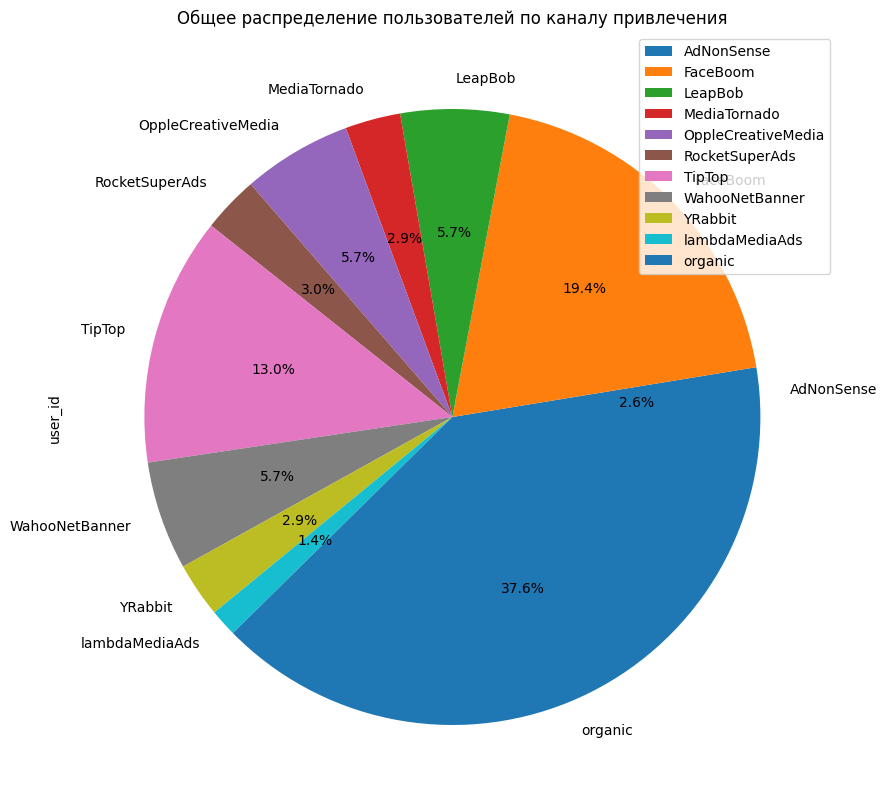

In [28]:
users_by_channel.sort_values(ascending=True, by = 'channel').plot(kind='pie', figsize=(10,10), y='user_id', 
                            labels=users_by_channel['channel'], autopct='%1.1f%%')
plt.title("Общее распределение пользователей по каналу привлечения")
plt.show()

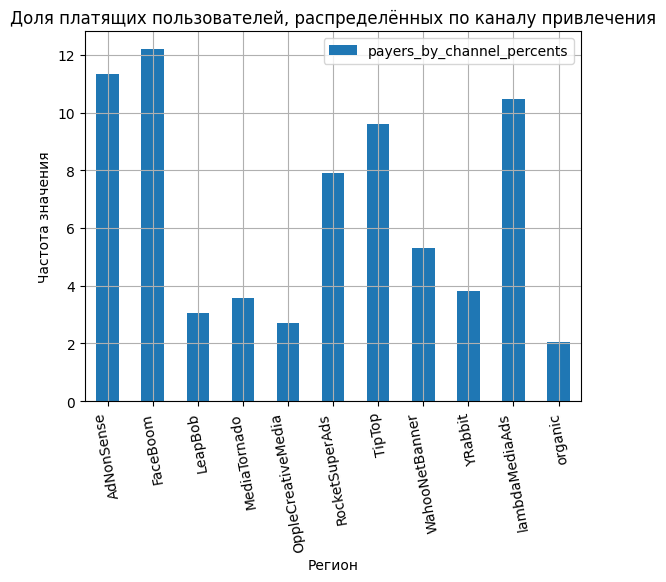

In [29]:
plot = users_by_channel.plot(x="channel", y="payers_by_channel_percents", kind='bar', grid=True, rot=100)
plot.set_title("Доля платящих пользователей, распределённых по каналу привлечения")
plot.set_xlabel("Регион")
plot.set_ylabel("Частота значения")
plt.show()

<b> Выводы </b>
* большинство пользователей, а именно 56439 находят приложение самостоятельно. Также популярные каналы - FaceBoom(29144) и TipTop(19561);
* наиболее популярные каналы у платящих пользователей - это FaceBoom, AdNonSense, lambdaMediaAds, TipTopи RocketSuperAds;
* самостоятельно пришедшие пользователи самые неплатящие, доля платежей всего 2,06%

Посчитаем общую сумму расходов на маркетинг

In [30]:
round(costs['costs'].sum())

105497

Выясним как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [31]:
costs_report = pd.DataFrame()
costs_report['costs'] = costs.groupby('channel')['costs'].sum()
costs_report.sort_values(by='costs', ascending=False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.

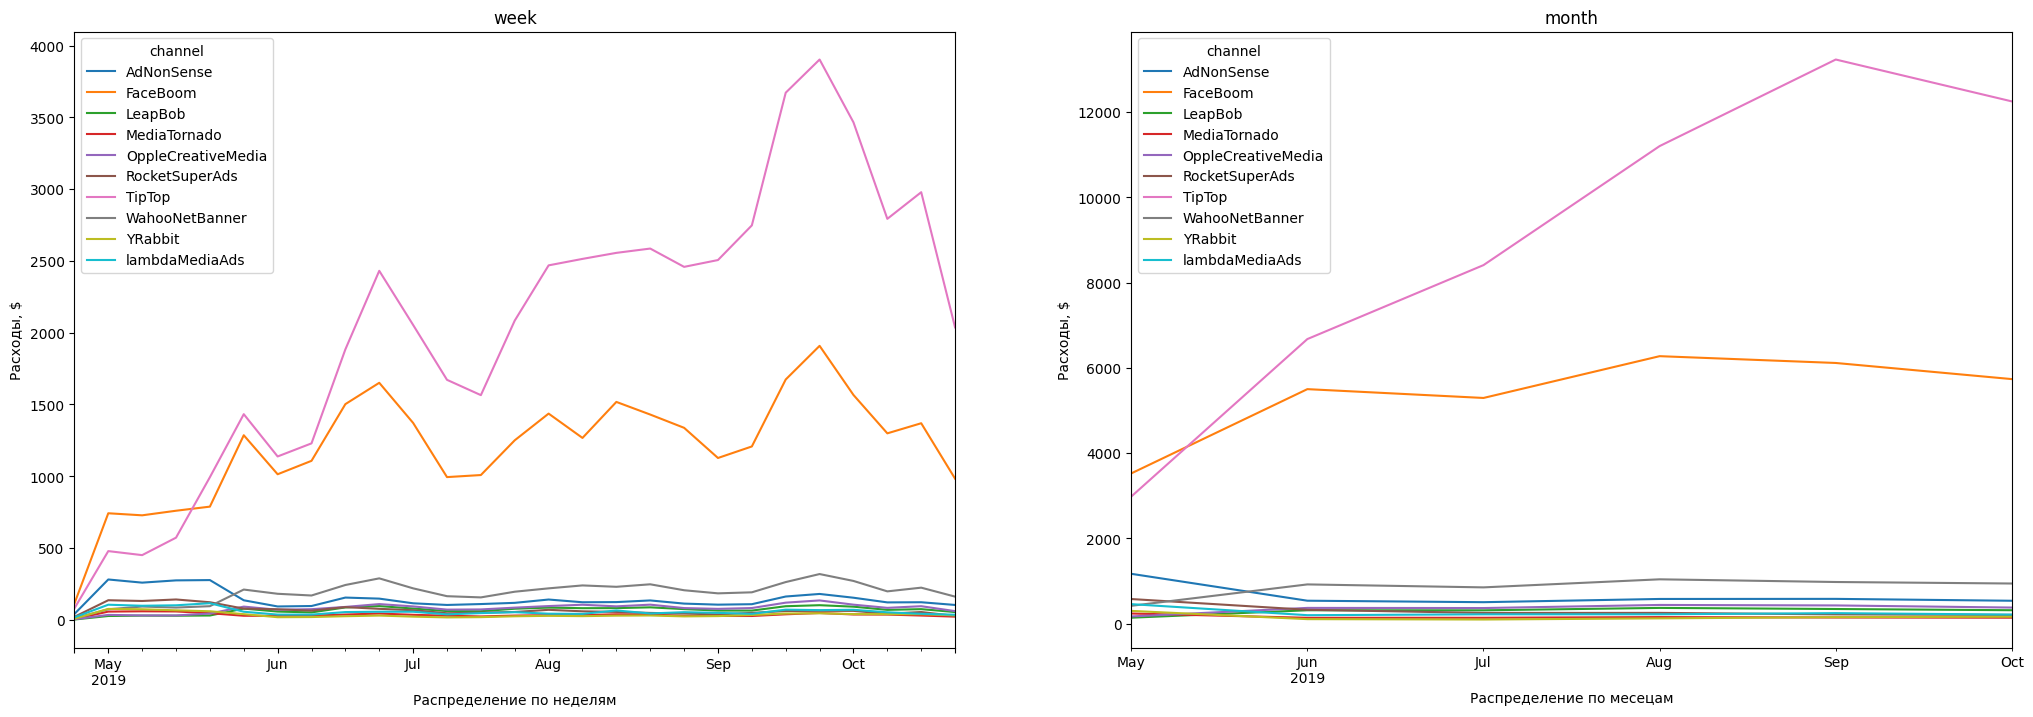

In [32]:
costs['week'] = costs['dt'].astype('datetime64[W]')
costs['month'] = costs['dt'].astype('datetime64[M]')
columns = ['week','month']
plt.subplots(figsize = (25, 8))
for i, col in enumerate(columns):
    costs.pivot_table(index = col, columns = 'channel', values = 'costs', aggfunc = 'sum').plot(ax = plt.subplot(1, 2, i + 1))
    plt.title(col)
    if col == 'week': 
        plt.xlabel('Распределение по неделям')
    if col == 'month': 
        plt.xlabel('Распределение по месецам')
    plt.ylabel('Расходы, $')
plt.show()

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

In [33]:
profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values('acquisition_cost', ascending=False)

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

<b> Выводы </b>
* наибольшие рекламные бюджеты зафиксированы на каналах привлечения TipTop(54751.30) и FaceBoom(32445.60). Остальные каналы привлечения заметно уступают
* рекламные расходы на канал привлечения FaceBoom распределены более равномерно нежели на TipTop. TipTop сильнее растет, но имеет резкие скачки к июлю 2019 года и в сентябре 2019 года;
* компания сделала упор на привлечение пользователей через каналы TipTop и FaceBoom;

### Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

Посчитаем общую сумму расходов на маркетинг

<b> Выводы </b>
* наибольшие рекламные бюджеты зафиксированы на каналах привлечения TipTop(54751.30) и FaceBoom(32445.60). Остальные каналы привлечения заметно уступают
* рекламные расходы на канал привлечения FaceBoom распределены более равномерно нежели на TipTop. TipTop сильнее растет, но имеет резкие скачки к июлю 2019 года и в сентябре 2019 года;
* компания сделала упор на привлечение пользователей через каналы TipTop и FaceBoom;

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [34]:
# считаем что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее 
# чем через две недели после привлечения.
observation_date = datetime.datetime(2019,11,1).date()
horizon_days = 14

In [35]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles.query('channel != "organic"'), orders, observation_date, horizon_days)

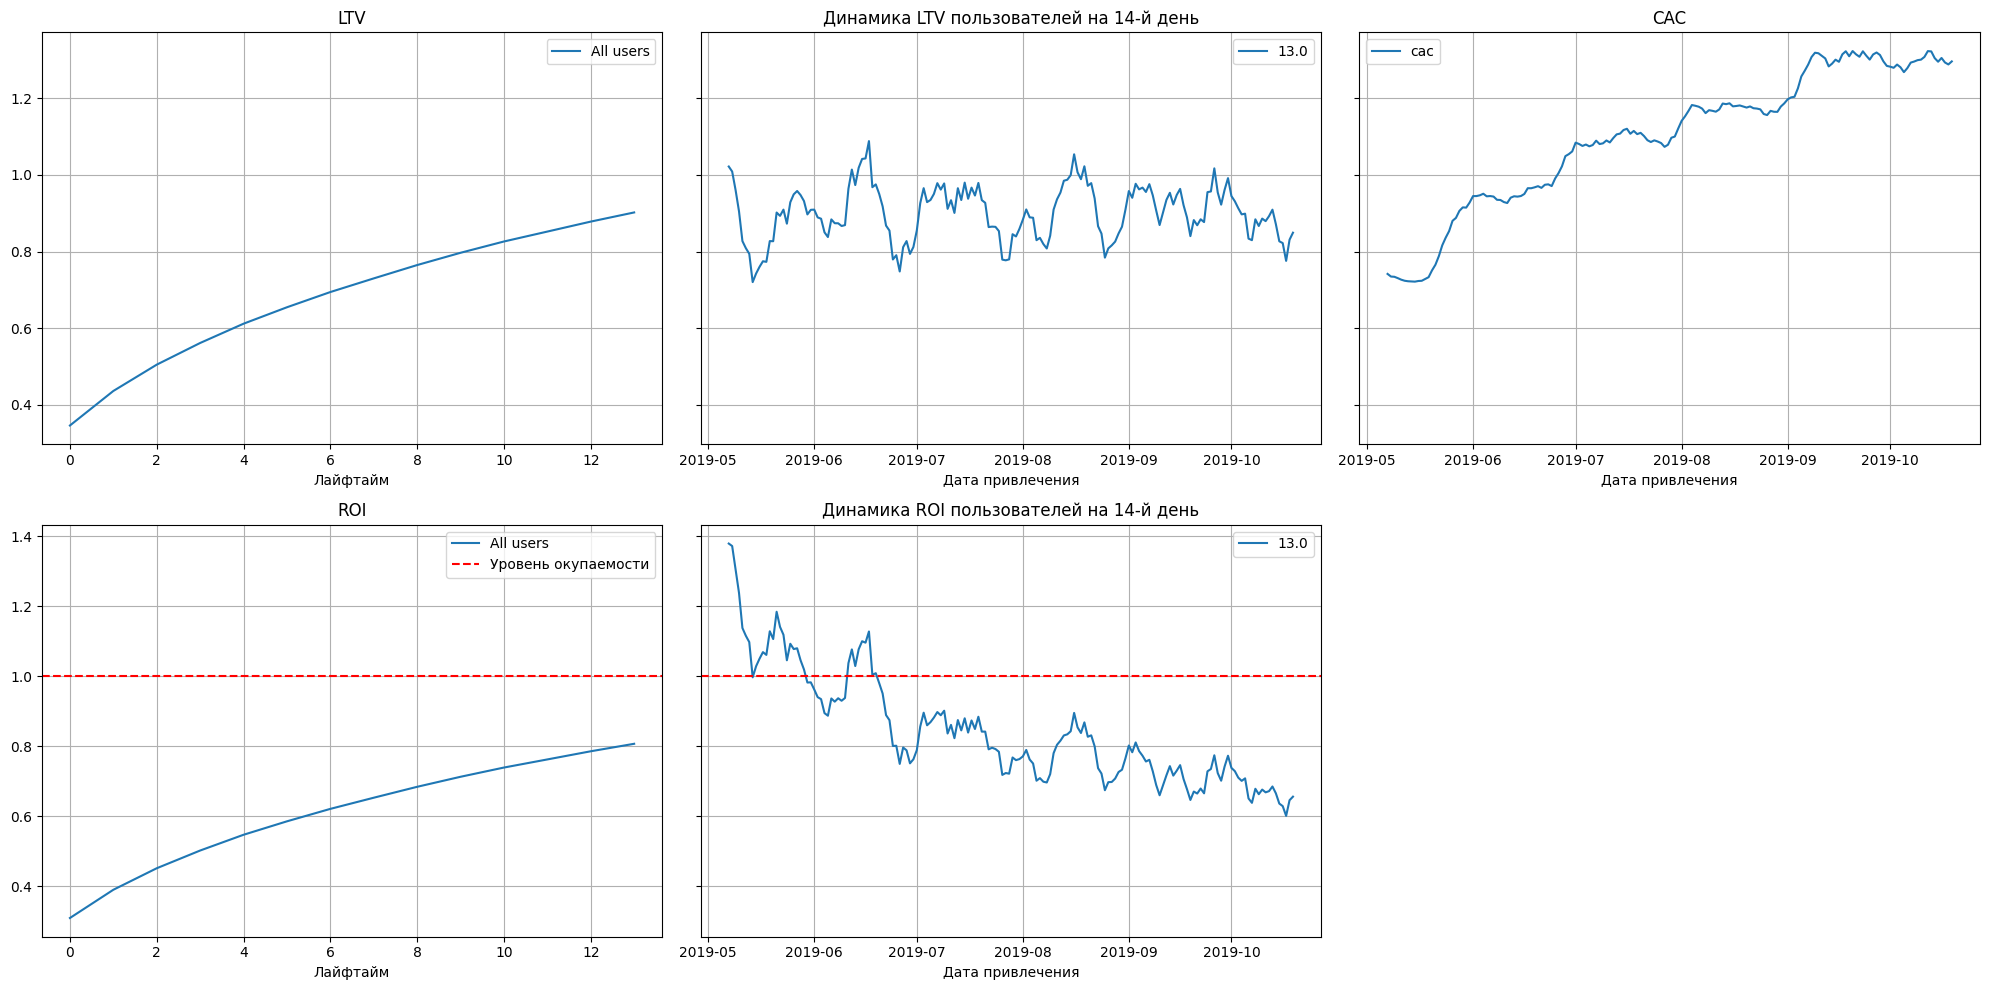

In [36]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

<b> Выводы </b>
* LTV стабильно растет, но к концу второй недели реклама так и не окупается, достигает значения около 80%
* динамика LTV пользователей имеет взлеты и падения во всём рассматриваемом периоде
* CAC на протяжении всего исследования растёт
* ROI так и не доходит до уровня окупаемости.
* пользователи впервые перестают окупаться начиная с июня, далее идёт подъем , а затем уверенное понижение

Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания. 

Сначала изучим конверсию и построим графики

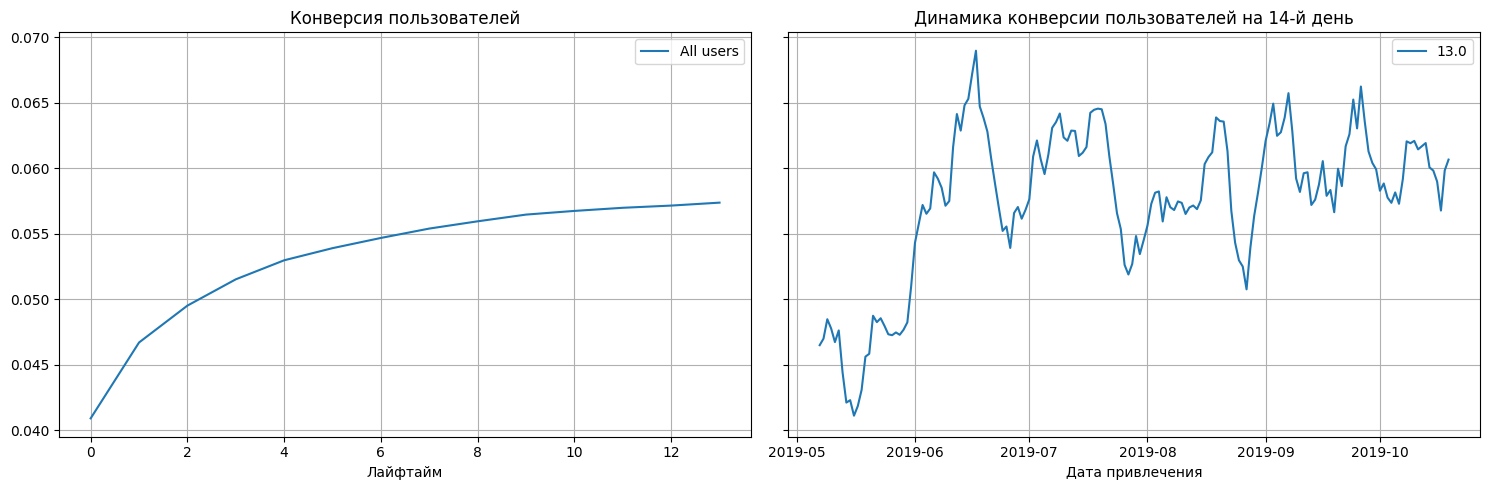

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Теперь изучим удержание платящих и неплатящих пользователей и построим графики

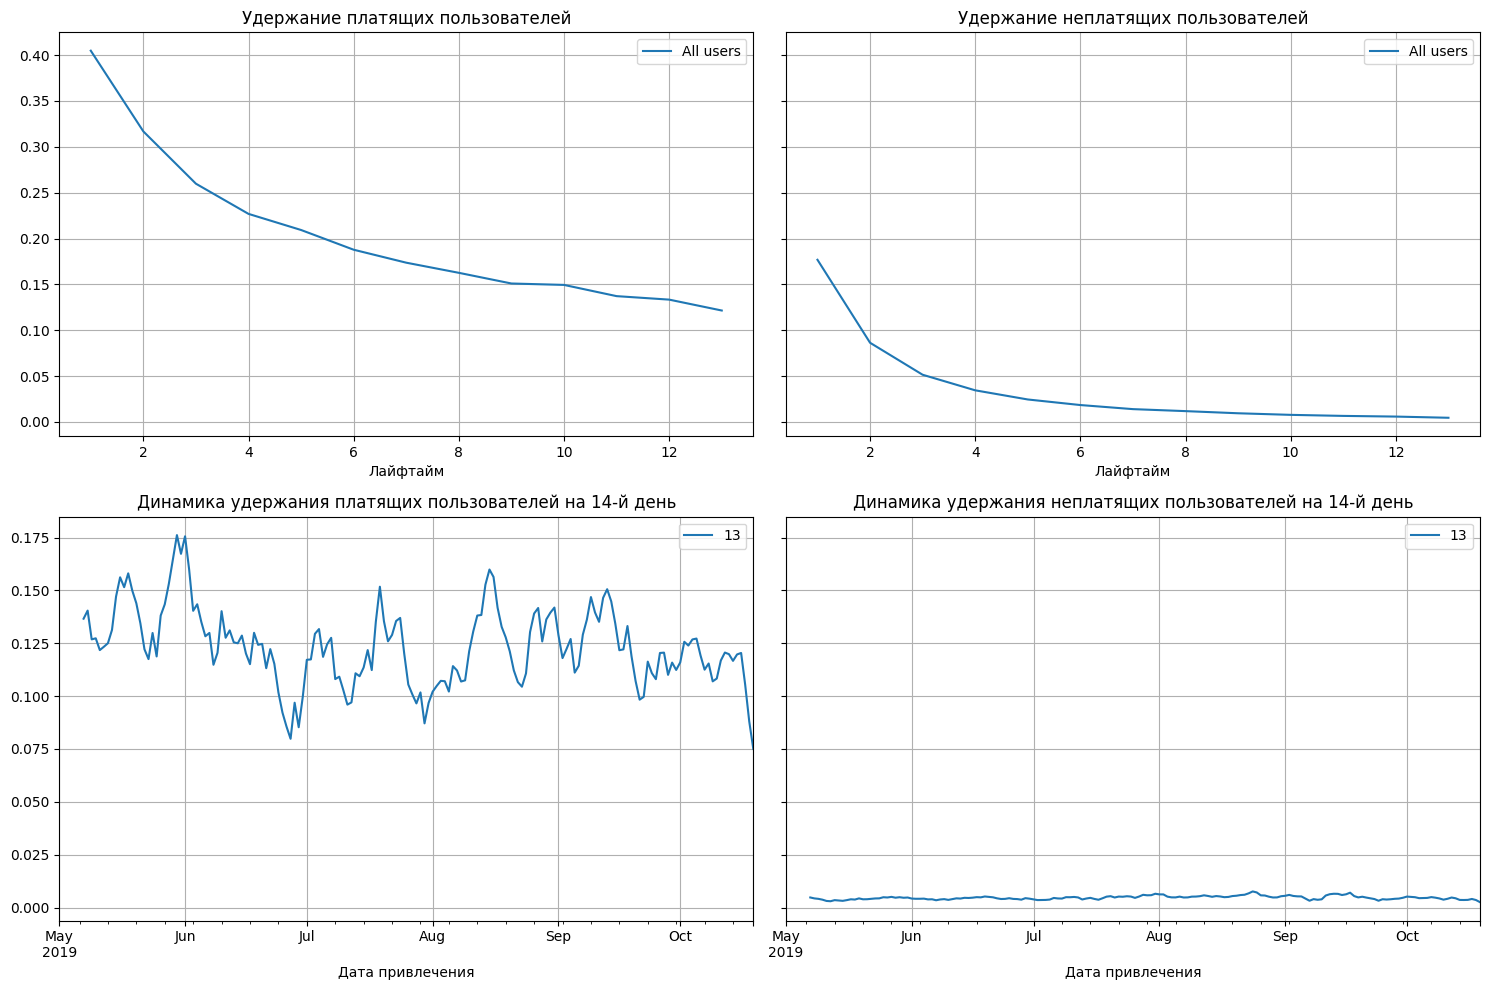

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days)
plot_retention(retention_grouped, retention_history, horizon_days) # построим графики для платящих и неплатящих пользователей

<b>Выводы</b>

* конверсия пользователей имеет тенденцию к повышению
* динамика конверсии пользователей имеет 4% в начале, но затем к третьему дню получает повышение до 5% и затем резких падений больше не имеет;
* около 10% платящих пользователей продолжают пользоваться приложением спустя 2 недели после привлечения;
* удержание неплатящих пользователей к концу второй недели стремится к нулю;
* к концу второй недели динамика удержания платящим пользователям стремится к значению 6%. Динамика стабильна;
* по неплатящим пользователям динамика удержания на протяжении всего периода исследования находится около 0

Проанализируем конверсию с разбивкой по устройствам

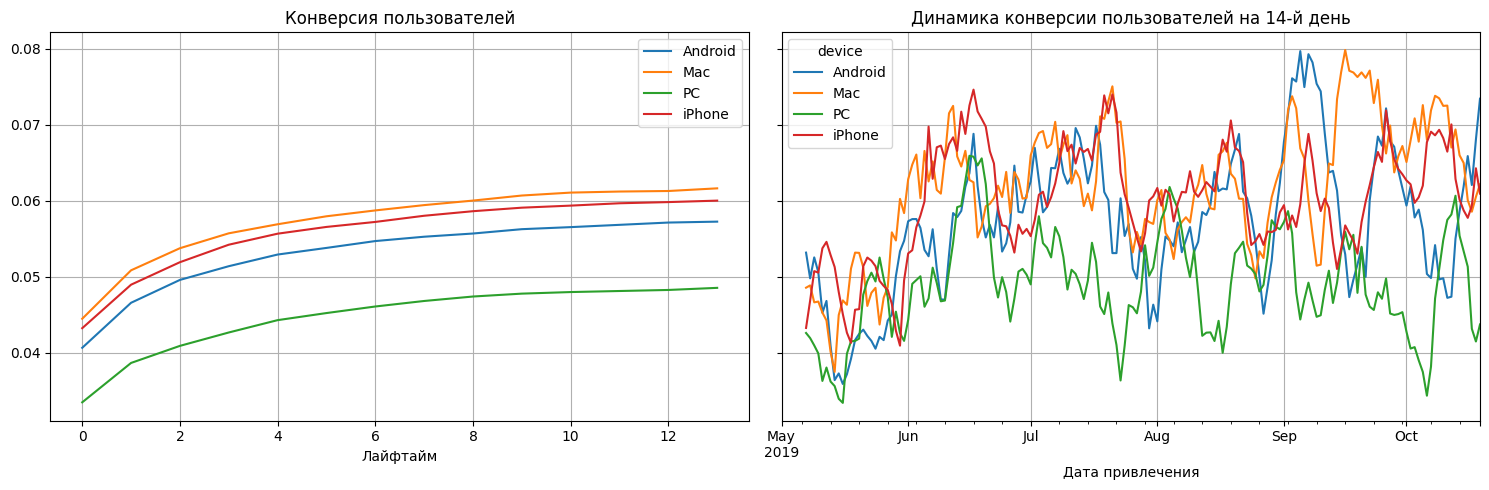

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion( profiles, orders, observation_date, horizon_days, dimensions = ['device'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

На основании графиков можно сделать вывод что пользователи Mac и iPhone конвертируются очень хорошо, причём постоянно. Похуже конвертируются пользователи Android. Хуже всего - PC.

Проанализируем удержание с разбивкой по устройствам

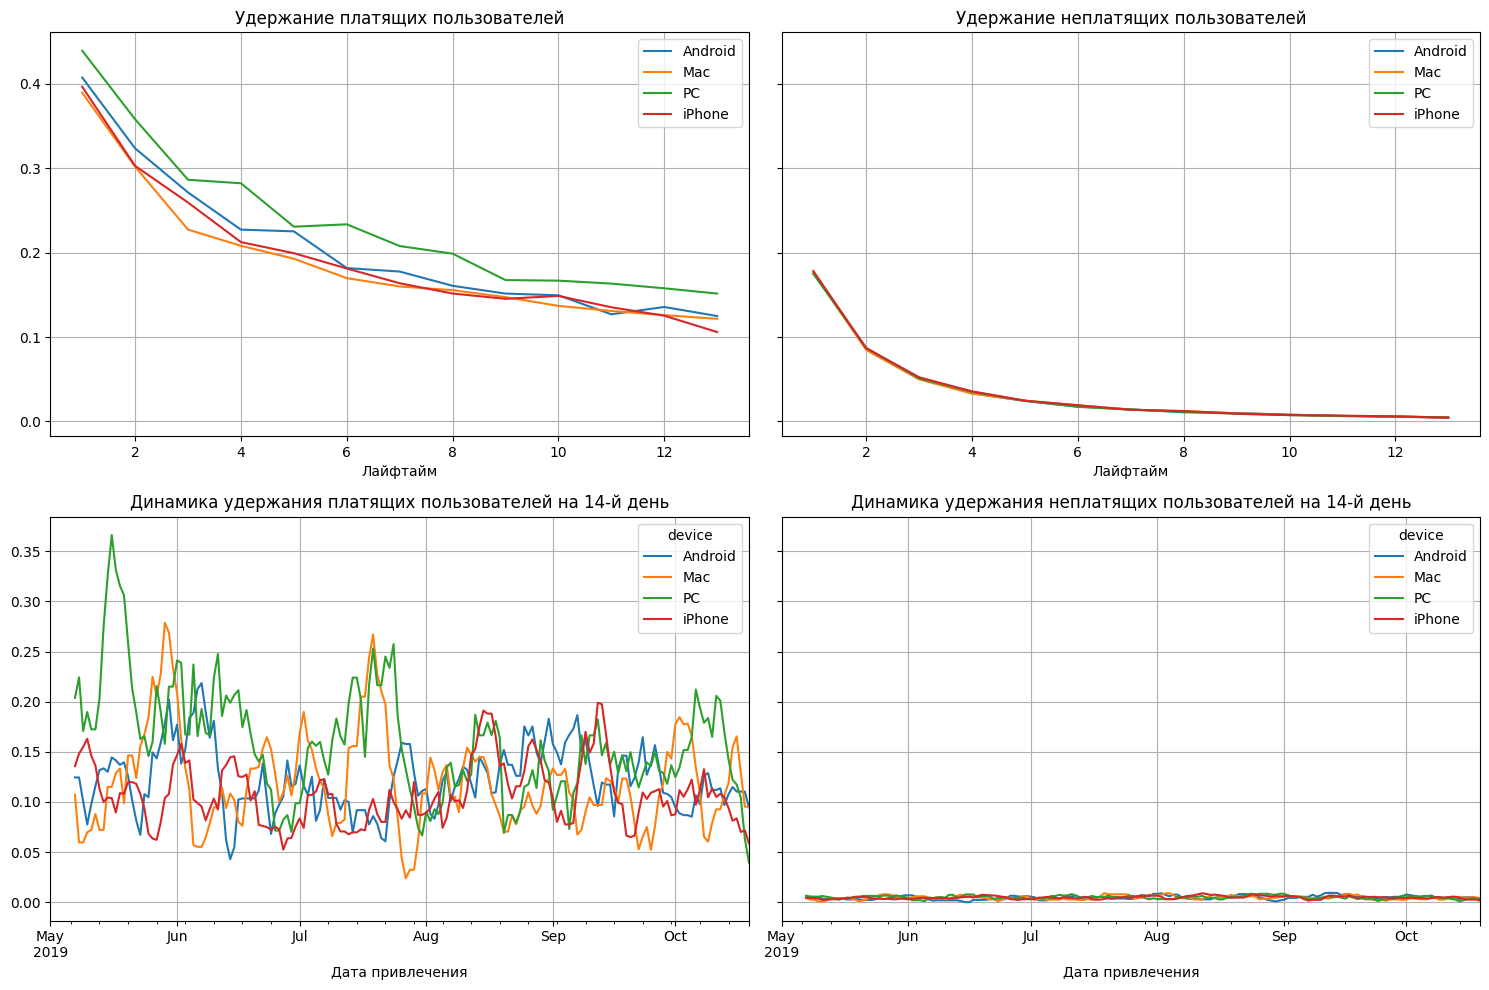

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = ['device'])
plot_retention(retention_grouped, retention_history, horizon_days) 

График показывает что лучше всего из платящих пользователей к концу исследования удерживатся пользователи iPhone. По неплатящим пользователям видна динамика к снижению к 0 по все устройствам.

Проанализируем конверсию с разбивкой по странам

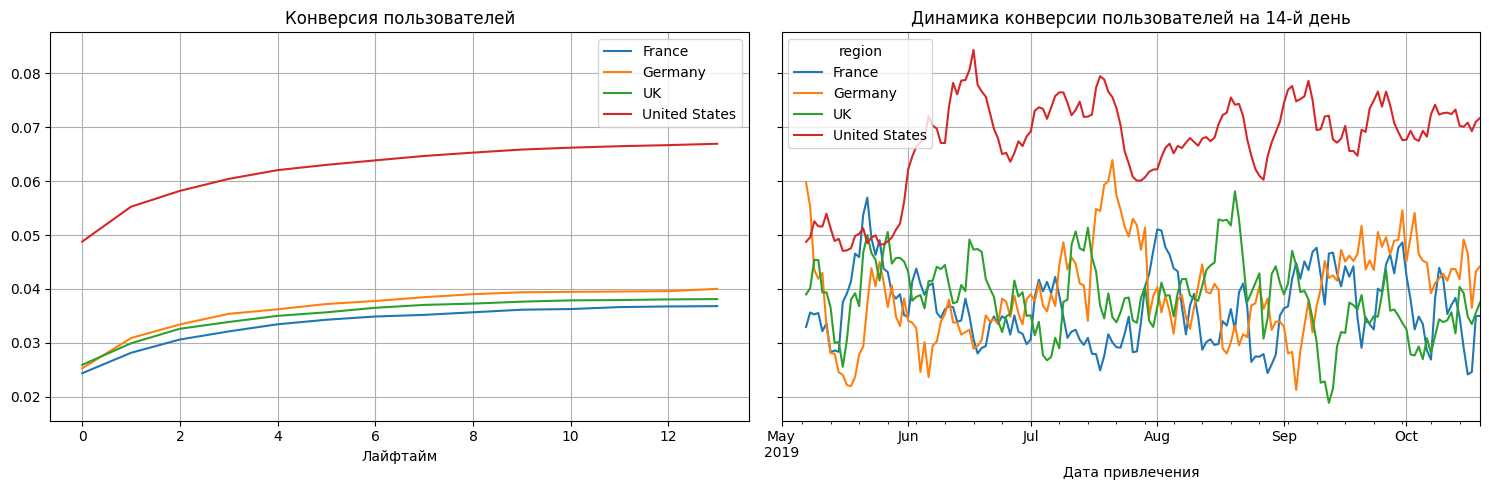

In [41]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = ['region'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

У пользователей приложения из США коверсия заметно выше нежели чем в других странах. В целом в рассматриваемом периоде конверсия пользователей в США также заметно выше.

Проанализируем удержание с разбивкой по странам

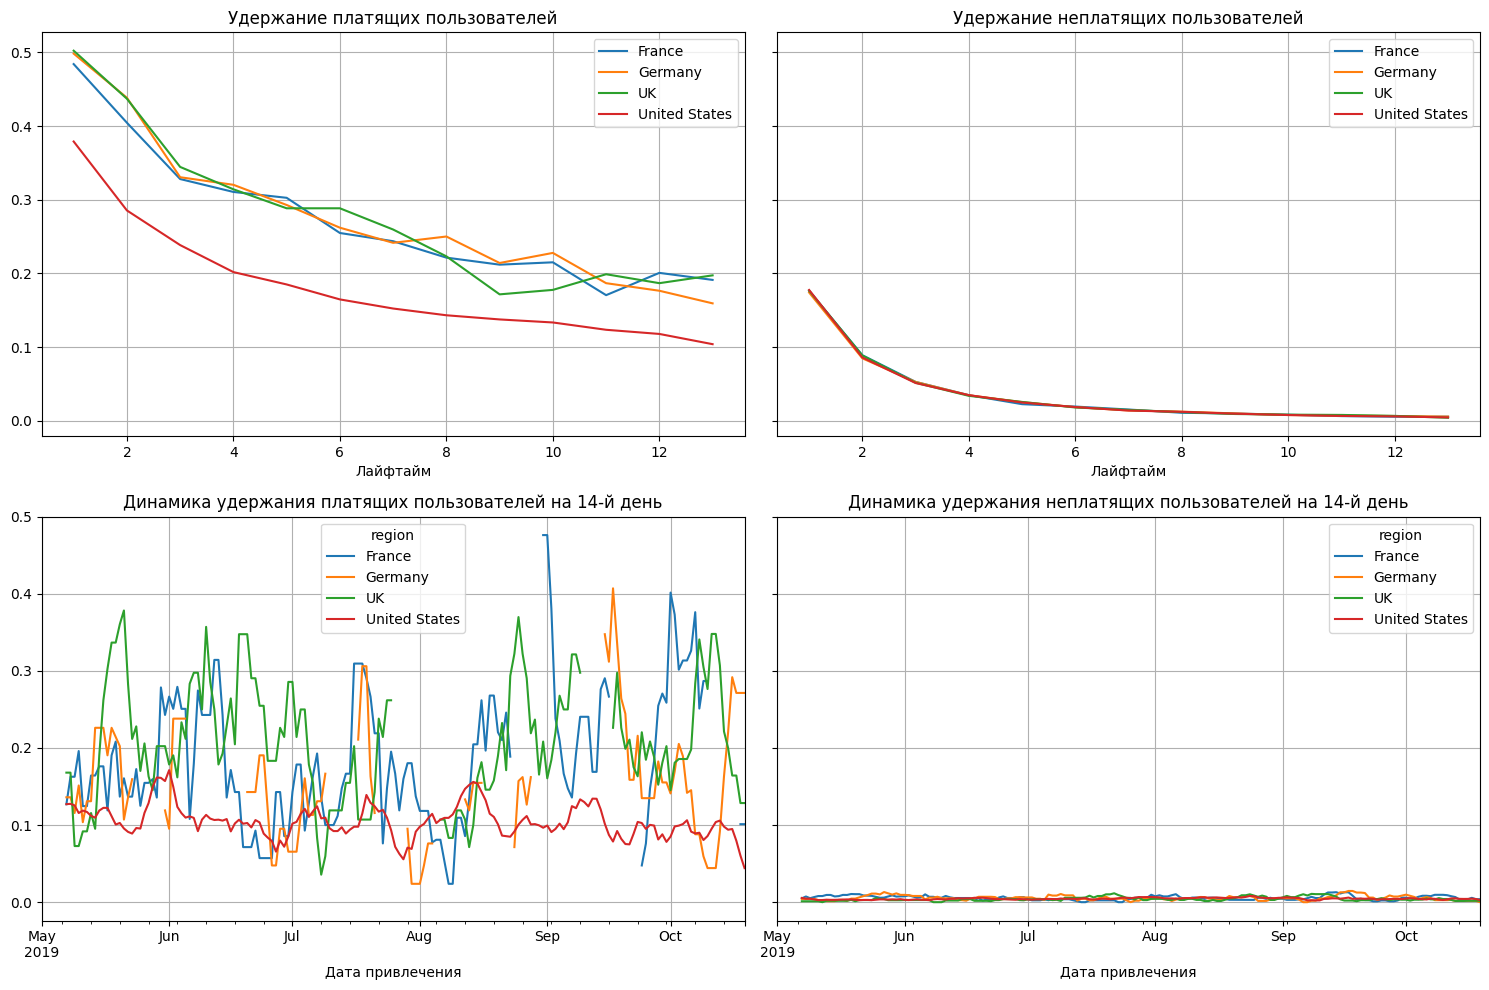

In [42]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = ['region'])
plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей из США самое низкое - к концу 5 дня 20%.

Проанализируем конверсию с разбивкой по каналам

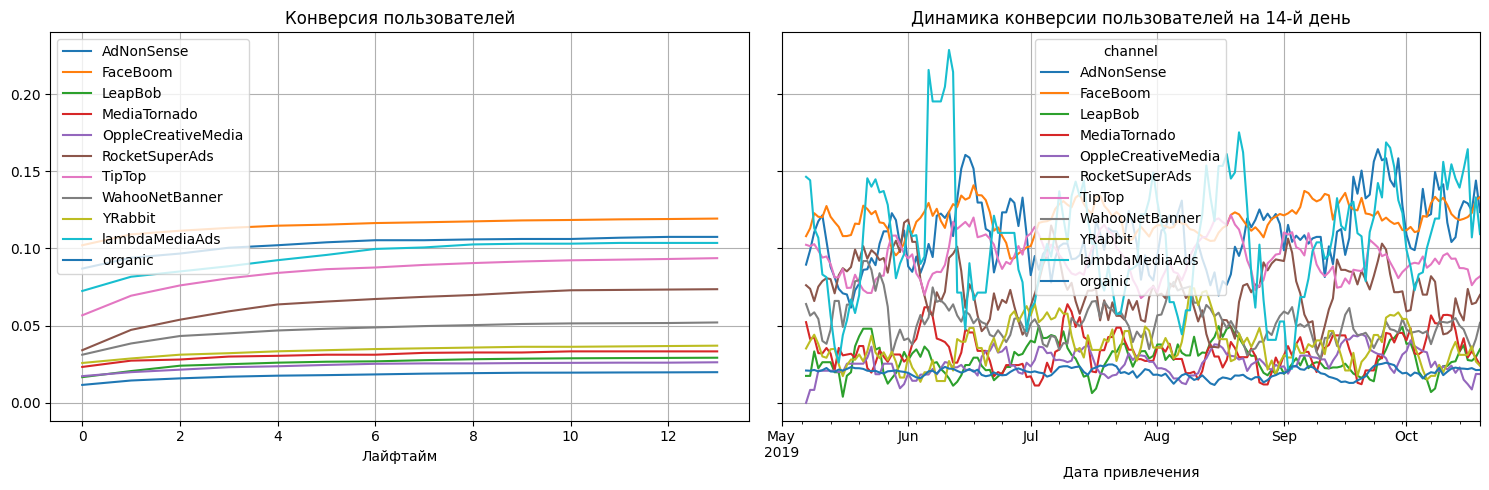

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = ['channel'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей из рассматриваемых каналах привлечения на протяжении всего лайфтайма имеют похожую динимику, но самое высокое значение конверсии и источника FaceBoom. Однако если брать в целом за рассматриваемый период максимальные значения конверсии у источника lambdaMediaAds.

Проанализируем удержание с разбивкой по каналам привлечения

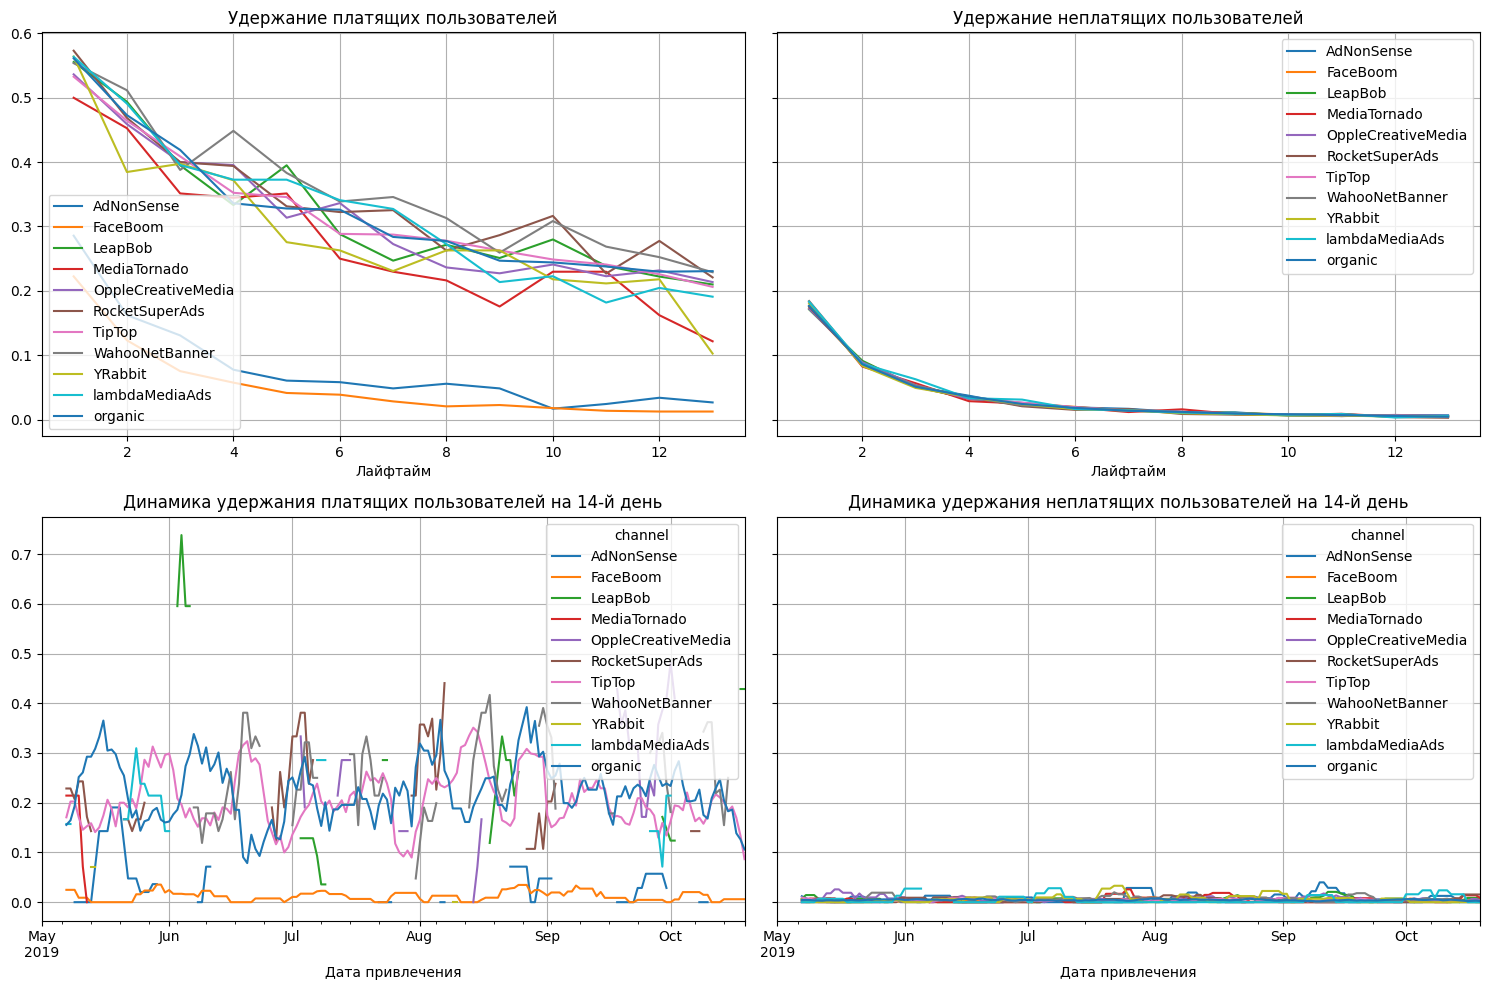

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = ['channel'])
plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей по каналам Faceboom самое низкое (меньше 5%).

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [45]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles.query('channel != "organic"'), orders, observation_date, horizon_days,dimensions = ['device']) 

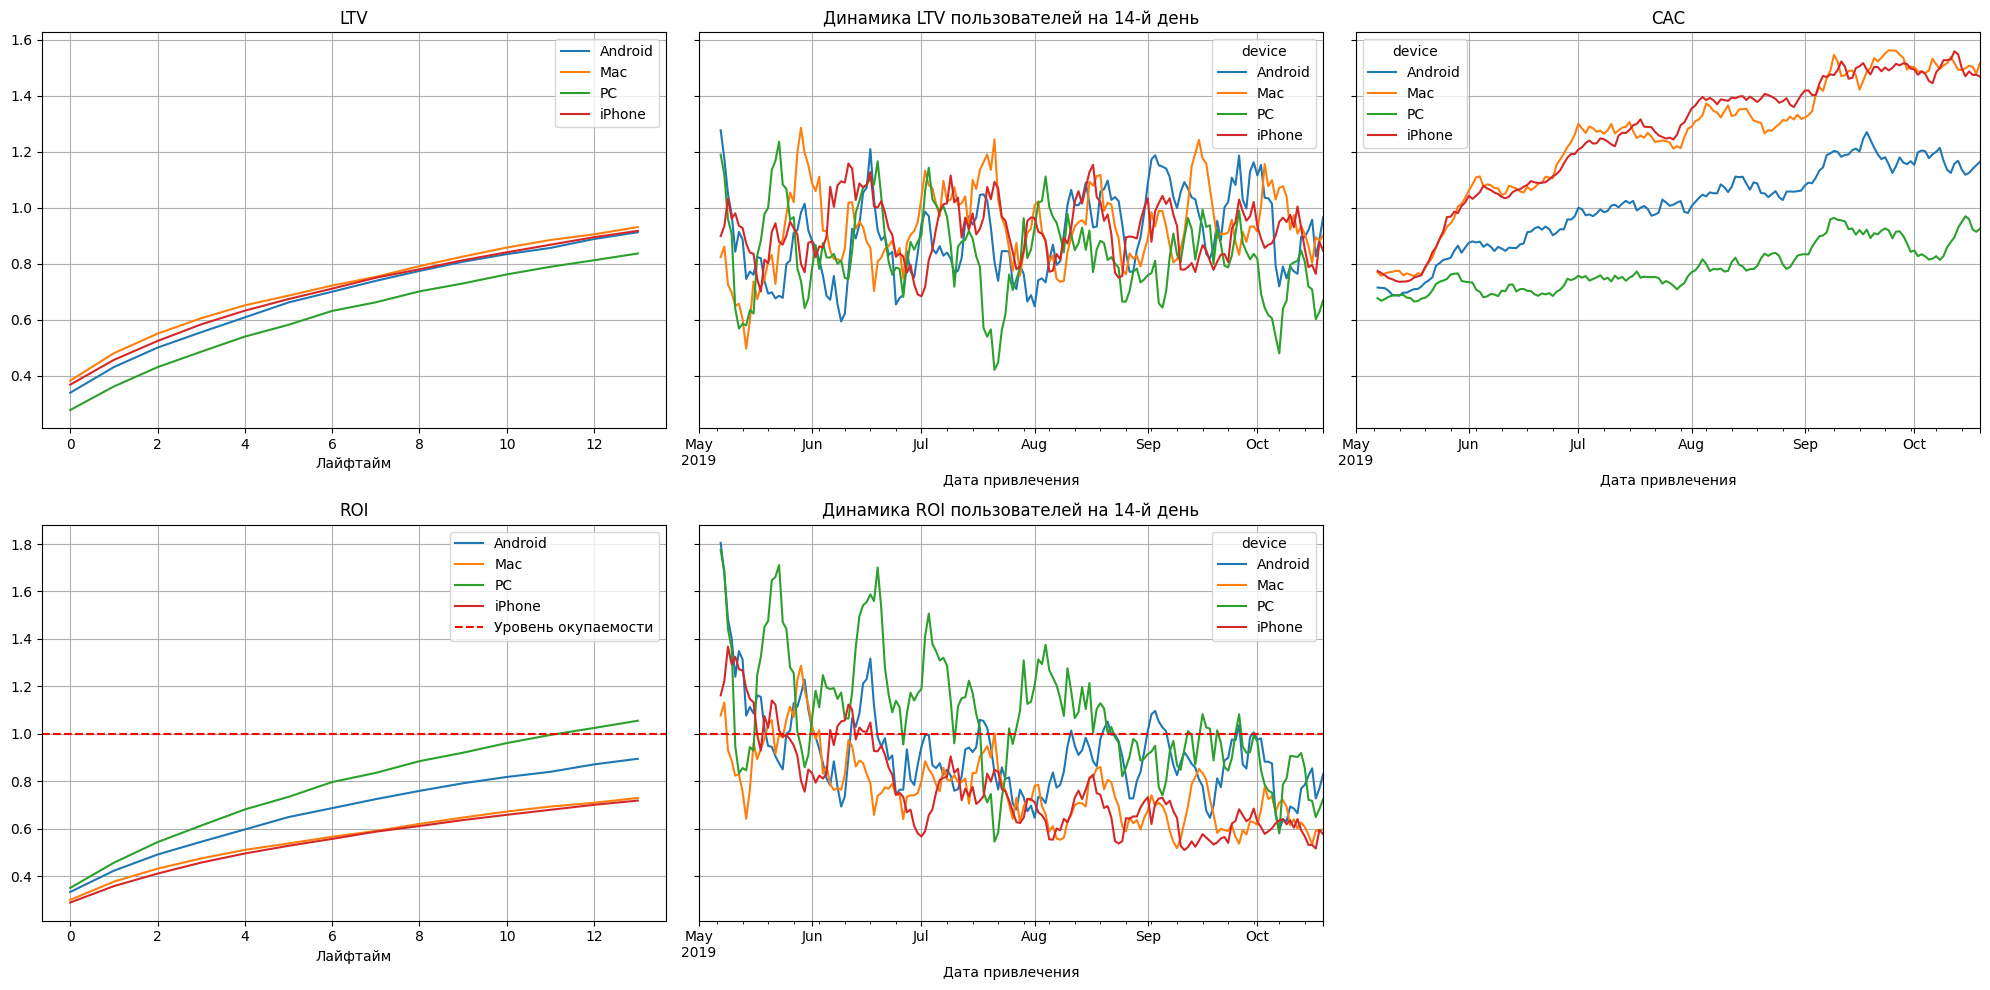

In [46]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

<b>Выводы</b>

* самый низкий LTV у пользователей PC
* в целом динамика LTV наиболее стабильна у пользователей iPhone, нет явных взлетов, но нет и явных падений;
* наиболее дорогостоящая реклама для приложения на iPhone и Mac. Можно сделать вывод что она не окупается на основании графика; ROI. Так как LTV для этих двух устройств постоянно растет, можно сделать вывод, что отсутствие окупаемости связано с высокой стоимостью рекламы;
* можно сделать вывод только про окупаемость рекламы только для приложения для PC. По остальным устройствам ROI не окупается.
* пользователи РС наиболее часто окупаются и за весь рассматриваемый период.

Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [47]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions = ['region']) 

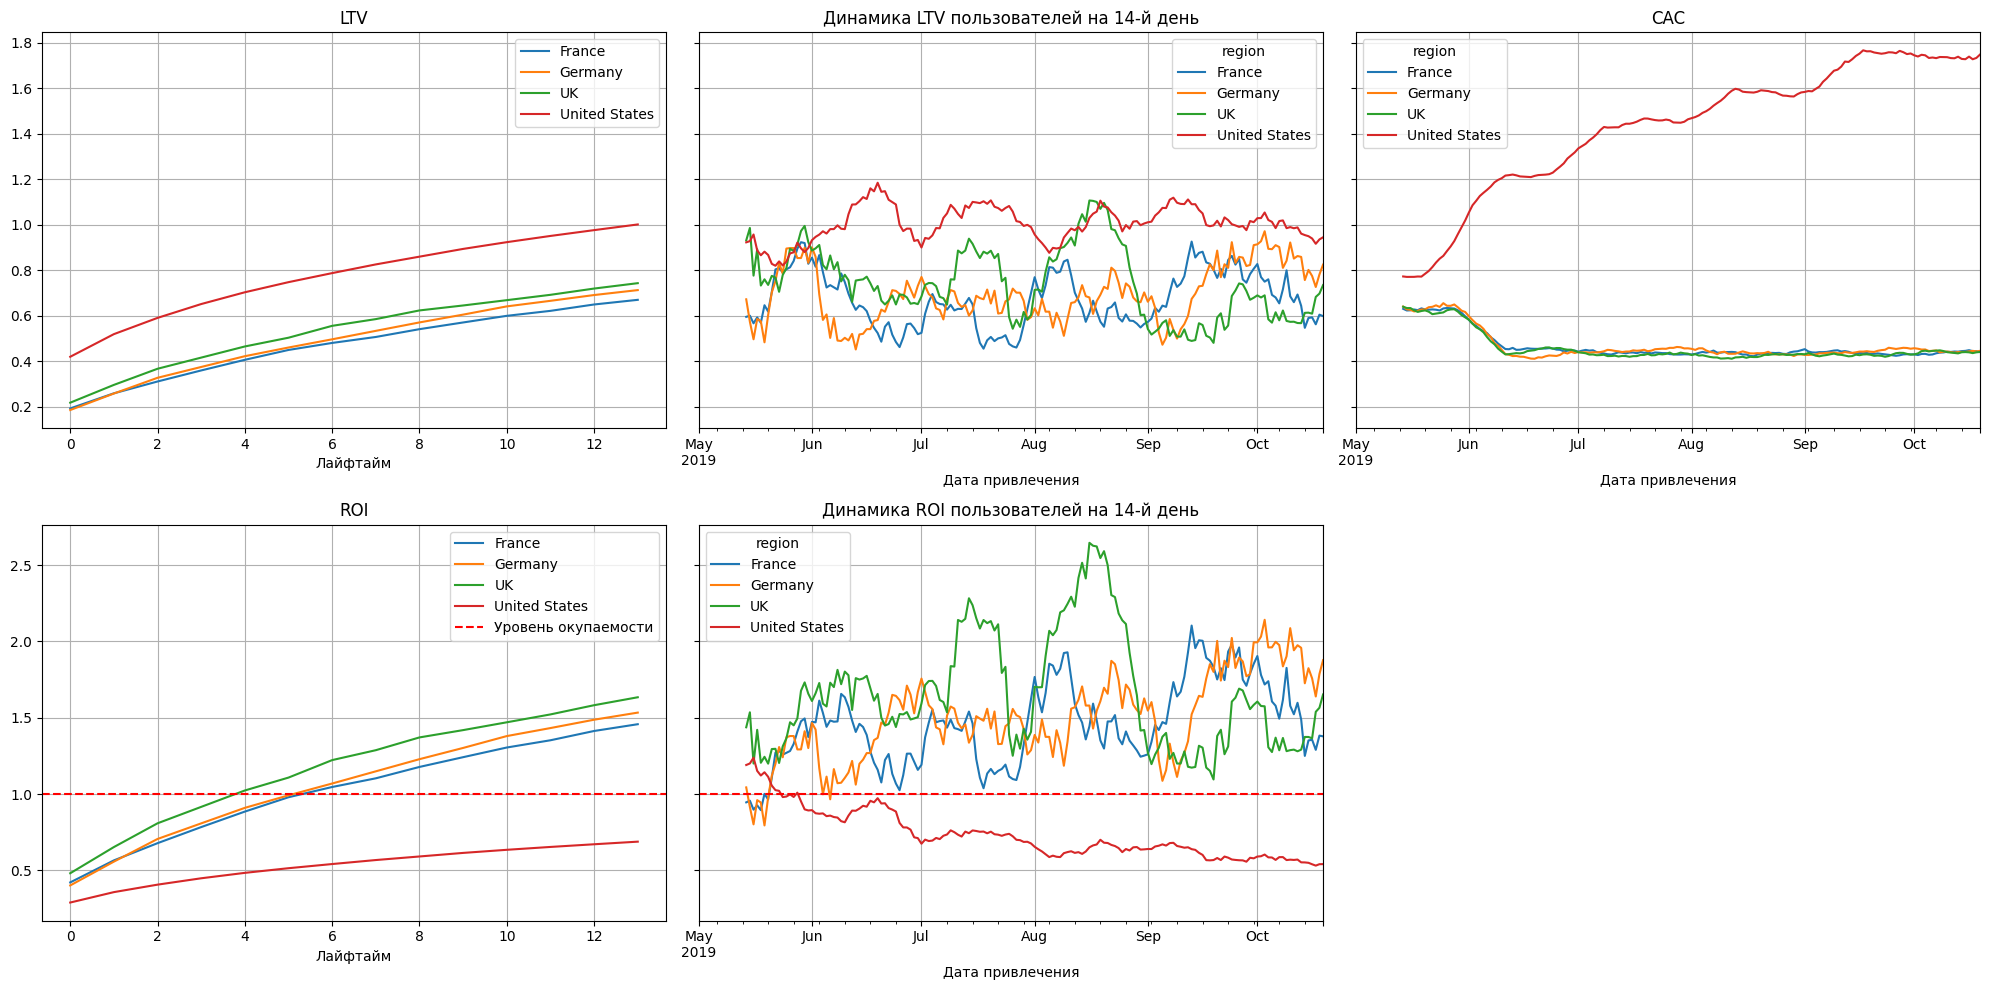

In [48]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

<b>Выводы</b>

* наиболее высокая ценность ценности клиента из США;
* за весь рассматриваемый период ценность пользователей из США также заметно выше;
* однако и расходы на рекламу в США гораздо выше чем у других стран;
* к концу рассматриваемого периода расходы на рекламу в США они так и не окупились, в отличие расходов на рекламу для других стран;
* можно сделать вывод о стабильной окупаемости инвестиций для всех стран кроме США.

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [49]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles.query('channel != "organic"'), orders, observation_date, horizon_days,dimensions = ['channel']) 

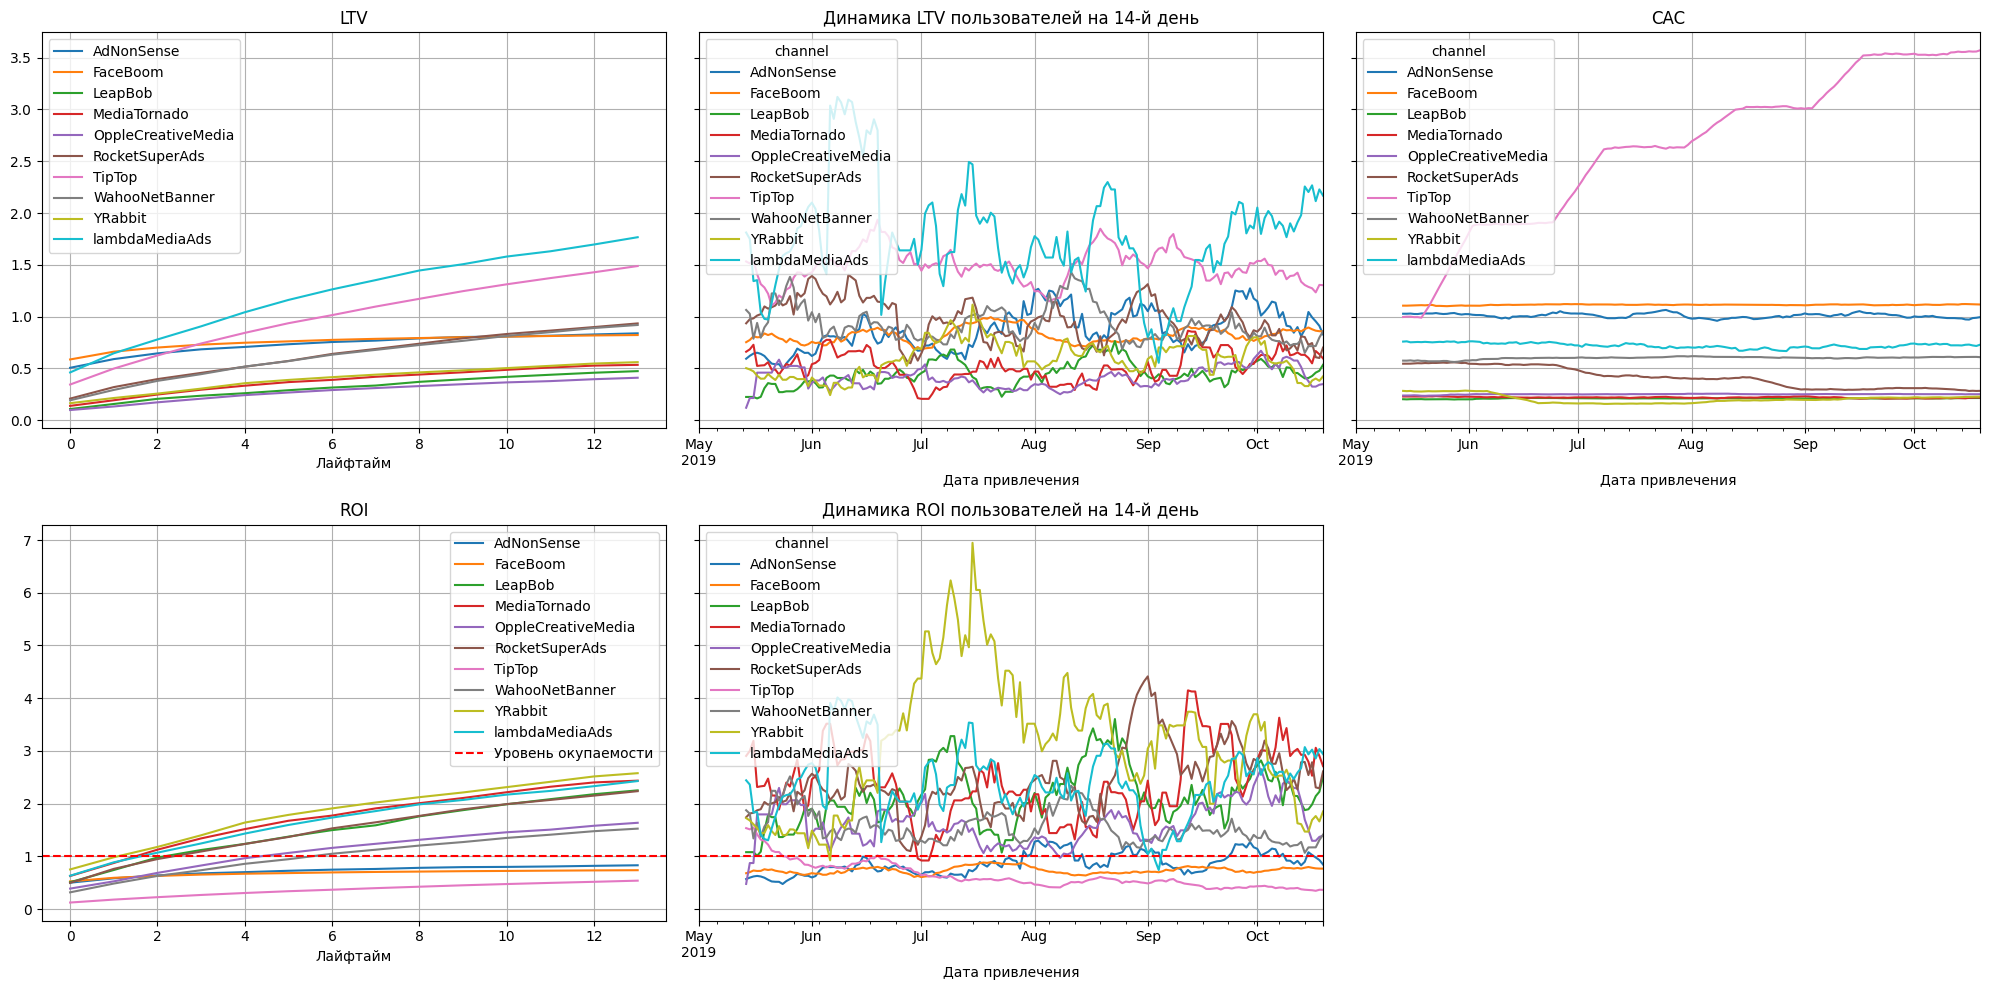

In [50]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

<b>Выводы</b>

* наиболее высокий пользовательский LTV у канала lambdaMediaAds;
* также по каналу lambdaMediaAds LTV пользователей в целом разительно выше, чем у других источников;
* расходы на привлечение пользователей резко растут только у TipTop;
* Не окупаются к концу 2 недели пользователи из каналов: TipTop, FaceBoom, AdNonSense.
* эти же каналы и не окупились в целом за рассматриваемый период.

<b>Окупается ли реклама, направленная на привлечение пользователей в целом?</b>

* вся прибыль от клиентов на периоде горизонта анализа растет;
* динамика LTV пользователей стабильна и колеблется около 0.7;
* динамика стоимости привлечения пользователей резко растет с июня 2019 вплоть до конца наблюдения;
* реклама не окупается, несмотря на увеличение рекламного бюджета, к концу второй недели только приближается к 100%;
* динамика ROI практически обратно пропорциональна динамики стоимости привлечения пользователей: чем больше средств тратится на привлечение, тем труднее ей окупиться.

<b>Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?</b>

Отрицательное влияние оказывают 3 канала привлечения: TipTop, FaceBoom, AdNonSence. По данным каналам к концу второй недели окупаемость так и не состоялась.
<br>Отрицательное влияние на окупаемость рекламы оказывает США. По данной стране ценность клиента заметно выше чем по другим странам, но и затраты на привлечение разительно выше чем у других стран.
<br>Отрицательное влияние на окупаемость рекламы оказывают пользователи Iphone и МАС. Пользователи данных устройств не окупают вложенные в их привлечение затраты.

<b>Чем могут быть вызваны проблемы окупаемости?</b>

Проблемы окупаемости могут быть вызваны ненормированным распределением средств на рекламу (в какой-то источник вложено больше средств, чем в остальные, а он не оправдал надежд), также возможно, что горизонт анализа недостаточен для того, чтобы пользователи окупились.

### Выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

Причины неэффективности привлечения пользователей:
* зафиксированы большие вложения в каналы, которые не окупаются. В частности TipTop и FaceBoom. А вот одновременно с этим удержание как платящих так и неплатящих пользователей у FaceBoom самое низкое, а конверсия наоборот самая высокая. Это говорит о том что возможно у данного канала привлечения раскрыта информация, не соответствующая ожиданиям клиентов.
* упор сделан на привлечение клиентов из США, привлечение пользователей из других страны заметно менее развито;
* возможно некорректная работа приложения для клиентов из США.

Рекомендации для отдела маркетинга:
* проанализировать причины низкого количества платящих пользователей в странах Европы. Уделить больше внимания завтратам на привлечение в данные страны;
* перераспределить рекламный бюджет на другие каналы. Рекомендуется рассмотреть rocketSuperAds. По нему зафиксировано наибольшее удержание платящих пользователей по рассматриваемому лайфтайму. При этом расходы на рекламу за весь рассматриваемый период одни из самых низких.
* сделать анализ целевой аудитории и работы приложения пользователей из США. Возможно работа приложения для пользователей США происходит некорректно.